# Importing necessary libraries

In [5]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import snscrape.modules.twitter as sntwitter
from better_profanity import profanity
from textblob import TextBlob 
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

## Applying filters while scraping data from twitter

In [2]:
filter_name = 'weather since:2021-02-24 until:2023-02-21 exclude:retweets exclude:replies lang:en'

scraper = sntwitter.TwitterSearchScraper(filter_name)
scraper
tweets = []
n_tweets = 100
for i, tweet in tqdm(enumerate(scraper.get_items()), total = n_tweets):
    data= [
        tweet.id,
        tweet.date,
        tweet.rawContent,
        tweet.user.username,
        tweet.likeCount,
        tweet.retweetCount,
        tweet.replyCount,
        tweet.lang,
        tweet.user.location
    ]
#     if tweet.lang == 'en':
    tweets.append(data)
    if i > n_tweets:
        break
tweet_df2 = pd.DataFrame(tweets, columns = ['id','datetime','rawcontent','username','likeCount','retweetCount','replyCount','language','location'])

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
(tweet_df2['language'] == 'en').count()

102

In [7]:
tweet_df2.sample(5)

,id,datetime,rawcontent,username,likeCount,retweetCount,replyCount,language,location
71,1627819384696672256,2023-02-20 23:55:59+00:00,"FINAL Prediction for Tuesday, February 21, 202...",VWeatherWatcher,14,1,2,en,Northeastern Pennsylvania
91,1627819164445310977,2023-02-20 23:55:06+00:00,"Hey Europe famjam, anybody wanna lemme know wt...",DinosaurChurch,2,1,5,en,Canada
23,1627820151088332801,2023-02-20 23:59:02+00:00,20/02/23 23:59\nCurrent conditions: Temp: 8.0C...,CM3Weather,0,0,0,en,"Little Waltham, CM3, England"
58,1627819620987011075,2023-02-20 23:56:55+00:00,Need this one tonight!,GaudetWeather,2,0,0,en,"Lexington, Kentucky"
65,1627819534752047105,2023-02-20 23:56:35+00:00,It was like this in my local @morrisons today....,SooozeKerr,0,2,0,en,"Suffolk, UK."


# Data Preprocessing

In [8]:
tweet_df = tweet_df2.copy()
tweet_df

,id,datetime,rawcontent,username,likeCount,retweetCount,replyCount,language,location
0,1627820372698562570,2023-02-20 23:59:54+00:00,"Sunset for February 20, 2023 at 05:31PM! Have ...",GallatinWeather,0,0,0,en,
1,1627820366725894144,2023-02-20 23:59:53+00:00,"Report at 00:00 \rWind:SW at av. 0mph, max gus...",HBayWeather,0,0,0,en,Sunny Herne Bay (the UK one)
2,1627820355183075328,2023-02-20 23:59:50+00:00,I think I froze half my piercings off in this ...,gymlifeanimal,200,3,37,en,On a beach somewhere
3,1627820344923783171,2023-02-20 23:59:48+00:00,Your weather for tomorrow @denverchannel https...,MikeNelson247,17,1,1,en,"Denver, CO"
4,1627820342084268034,2023-02-20 23:59:47+00:00,"9 years ago today in Breckinridge, Colorado! I...",GamecockSmoke,1,0,0,en,
...,...,...,...,...,...,...,...,...,...
97,1627819146028146693,2023-02-20 23:55:02+00:00,"Wichita Weather 61F at 5:55 PM, Wind WNW 1 Gus...",SouthWindWX,0,0,0,en,
98,1627819141544419331,2023-02-20 23:55:01+00:00,"Dixon, MO At: 5:55 PM Temp: 57.4°F Visibility:...",dixonweather,0,0,0,en,"Dixon, Missouri USA"
99,1627819138252001280,2023-02-20 23:55:00+00:00,"Wind 5 mph ENE. Barometer 1017.71 hPa, Falling...",quarmbyweather,0,0,0,en,Huddersfield
100,1627819128370110465,2023-02-20 23:54:58+00:00,There is a Fire Weather Watch on Tuesday and a...,KCBD11,0,0,0,en,"Lubbock, TX"


## Convert datetime to date

In [9]:
tweet_df.insert(2, 'date', pd.to_datetime(tweet_df['datetime']).dt.strftime('%Y-%m-%d'))
tweet_df.drop('datetime',axis=1,inplace=True)
tweet_df.sample(5)

,id,date,rawcontent,username,likeCount,retweetCount,replyCount,language,location
70,1627819419589087232,2023-02-20,Tracking Temps in #ATX. Here's how today compa...,ChikageWeather,2,0,0,en,"Austin, TX"
38,1627819935450927104,2023-02-20,A series of passing disturbances will keep uns...,nwsjacksonky,2,1,0,en,"Jackson, KY"
46,1627819812981207040,2023-02-20,"Right now: Smoke, Temperature: 21.02C, Humidit...",WeatherAmdavad,0,0,0,en,Ahmedabad
89,1627819189313347585,2023-02-20,Delhi Weather: Delhi’s heat broke a 17-year re...,DEENEWS_IN,0,0,0,en,
41,1627819916257640448,2023-02-20,I can’t comment on whether it’s the weather or...,kentbuse,0,0,1,en,"Cambridge, England"


## save as csv

In [10]:
tweet_df.to_csv(f"dataset/{'weather'}.csv", index = False)

## import scraped csv

In [8]:
w_df = pd.read_csv(f"dataset/{'weather'}.csv")
w_df

,id,date,rawcontent,username,likeCount,retweetCount,replyCount,language,location
0,1627820372698562570,2023-02-20,"Sunset for February 20, 2023 at 05:31PM! Have ...",GallatinWeather,0,0,0,en,NaN
1,1627820371607945217,2023-02-20,I guess our govt decided to stop playing whack...,fusion_allusion,0,0,0,en,NaN
2,1627820366725894144,2023-02-20,"Report at 00:00 \rWind:SW at av. 0mph, max gus...",HBayWeather,0,0,0,en,Sunny Herne Bay (the UK one)
3,1627820355183075328,2023-02-20,I think I froze half my piercings off in this ...,gymlifeanimal,197,2,37,en,On a beach somewhere
4,1627820344923783171,2023-02-20,Your weather for tomorrow @denverchannel https...,MikeNelson247,17,1,1,en,"Denver, CO"
...,...,...,...,...,...,...,...,...,...
97,1627819151799767040,2023-02-20,"Weather-Frankston, Australia @ 10:55 Temp-19.1...",frankstonwethr,0,0,0,en,NaN
98,1627819146028146693,2023-02-20,"Wichita Weather 61F at 5:55 PM, Wind WNW 1 Gus...",SouthWindWX,0,0,0,en,NaN
99,1627819141544419331,2023-02-20,"Dixon, MO At: 5:55 PM Temp: 57.4°F Visibility:...",dixonweather,0,0,0,en,"Dixon, Missouri USA"
100,1627819138252001280,2023-02-20,"Wind 5 mph ENE. Barometer 1017.71 hPa, Falling...",quarmbyweather,0,0,0,en,Huddersfield


## Check for null values

In [9]:
w_df.isnull().sum()

id               0
date             0
rawcontent       0
username         0
likeCount        0
retweetCount     0
replyCount       0
language         0
location        22
dtype: int64

## Performing EDA

In [10]:
w_df.loc[w_df['likeCount']>=10]

,id,date,rawcontent,username,likeCount,retweetCount,replyCount,language,location
3,1627820355183075328,2023-02-20,I think I froze half my piercings off in this ...,gymlifeanimal,197,2,37,en,On a beach somewhere
4,1627820344923783171,2023-02-20,Your weather for tomorrow @denverchannel https...,MikeNelson247,17,1,1,en,"Denver, CO"
10,1627820303844868097,2023-02-20,Peaceful sunset over Morse after a wonderful M...,MorseLakeWeathe,23,0,2,en,Hamilton County Indiana
19,1627820184324001792,2023-02-20,Winds increase late Tuesday with gusts to 40 p...,MandyBaileyWX,10,3,0,en,Philippians 3:7-8
38,1627819938789441545,2023-02-20,Significant coast-to-coast storm will sweep ac...,Beginning22End,13,2,5,en,Rumble: pray4america
40,1627819933492219904,2023-02-20,A very strong weather system will produce pote...,JoeKOAT,12,3,0,en,"Albuquerque, NM"
43,1627819909303377920,2023-02-20,Massive #winterstorm. It covers basically the ...,tymetwx,10,2,0,en,NaN
65,1627819550027939840,2023-02-20,#goodmorning #Beijing \nwhat a beautiful weath...,ChanJoe18,14,2,1,en,NaN
69,1627819464594006021,2023-02-20,I need the weather to pick a side because this...,YuneKokoro,32,0,3,en,The Dark Alleyway
72,1627819384696672256,2023-02-20,"FINAL Prediction for Tuesday, February 21, 202...",VWeatherWatcher,14,1,2,en,Northeastern Pennsylvania


In [11]:
w_df.loc[(w_df['likeCount']>4)&(w_df['retweetCount']>2)]

,id,date,rawcontent,username,likeCount,retweetCount,replyCount,language,location
19,1627820184324001792,2023-02-20,Winds increase late Tuesday with gusts to 40 p...,MandyBaileyWX,10,3,0,en,Philippians 3:7-8
40,1627819933492219904,2023-02-20,A very strong weather system will produce pote...,JoeKOAT,12,3,0,en,"Albuquerque, NM"
79,1627819294250905603,2023-02-20,A late February weather system blowing into We...,DougPigsleyKOMO,20,4,0,en,NaN
89,1627819200835092481,2023-02-20,#ONStorm #ONwx Good evening! We've got a quick...,IWeatherON,270,67,18,en,"Ontario, Canada"


# Cleaning the tweets

In [12]:
tweet_list = w_df.rawcontent.to_list()

In [13]:
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    r = tweet.lower()
    r = profanity.censor(r)
    r = re.sub("'", "", r) # This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r) # remove mentions
    r = re.sub("#[A-Za-z0-9_]+","", r) # remove hashtags
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

In [14]:
w_df['cleanedTweets'] = w_df['rawcontent'].apply(clean_tweet)

C:\Users\Hari\AppData\Local\Temp\ipykernel_21928\3107068827.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


# Comparing raw tweets and cleaned tweets

In [15]:
w_df[['rawcontent','cleanedTweets']].head(7)

,rawcontent,cleanedTweets
0,"Sunset for February 20, 2023 at 05:31PM! Have ...",sunset february 20 2023 at 05 31pm have good n...
1,I guess our govt decided to stop playing whack...,i guess our govt decided stop playing whack mo...
2,"Report at 00:00 \rWind:SW at av. 0mph, max gus...",report at 00 00 wind sw at av 0mph max gust to...
3,I think I froze half my piercings off in this ...,i think i froze half my piercings off this col...
4,Your weather for tomorrow @denverchannel https...,your weather tomorrow
5,"9 years ago today in Breckinridge, Colorado! I...",9 years ago today breckinridge colorado if onl...
6,it’s the fact that it was nice this weekend an...,it s fact that it was nice this weekend i m st...


## copy cleaned tweet to new dataframe

In [16]:
sentiment_df =  w_df[['cleanedTweets']].copy()

In [17]:
sentiment_df

,cleanedTweets
0,sunset february 20 2023 at 05 31pm have good n...
1,i guess our govt decided stop playing whack mo...
2,report at 00 00 wind sw at av 0mph max gust to...
3,i think i froze half my piercings off this col...
4,your weather tomorrow
...,...
97,weather frankston australia 10 55 temp 19 1 c ...
98,wichita weather 61f at 5 55 pm wind wnw 1 gust...
99,dixon mo at 5 55 pm temp 57 4 f visibility 10 ...
100,wind 5 mph ene barometer 1017 71 hpa falling s...


## import additional libraries

In [18]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import enchant
from nltk import FreqDist

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Spell Checker

In [19]:
import enchant

def spell_check(text):
    d = enchant.Dict("en_US") # initialize English dictionary
    words = text.split() # split text into words
    corrected_words = [] # initialize list to store corrected words
    for word in words:
        if d.check(word): # check if word is spelled correctly
            corrected_words.append(word) # add word to list if spelled correctly
        else:
            suggestions = d.suggest(word) # get suggestions for misspelled word
            if suggestions:
                corrected_words.append(suggestions[0]) # add first suggestion to list
            else:
                corrected_words.append(word) # add original word to list if no suggestions found
    return " ".join(corrected_words) # join corrected words back into a sentence

# Tokenization

In [20]:
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens


# Lemmatization

In [21]:
def lemmatize(tokens):
    lemmas = []
    for token in tokens:
        lemma = WordNetLemmatizer().lemmatize(token)
        if len(lemma) > 1 and not lemma.isnumeric():
            lemmas.append(lemma.lower())
    return lemmas


# Stop words removal

In [22]:
def remove_stopwords(tokens):
    stopwords = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return filtered_tokens

# applying and creating dataframe

In [23]:
sentiment_df['cleanedTweets'] = sentiment_df['cleanedTweets'].apply(lambda x: spell_check(x))
sentiment_df['tokens'] = sentiment_df['cleanedTweets'].apply(lambda x: tokenize(x))
sentiment_df['lemmas'] = sentiment_df['tokens'].apply(lambda x: lemmatize(x))
sentiment_df['cleanedTokens'] = sentiment_df['lemmas'].apply(lambda x: remove_stopwords(x))

In [24]:
sentiment_df

,cleanedTweets,tokens,lemmas,cleanedTokens
0,sunset February 20 2023 at 05 31pm have good n...,"[sunset, February, 20, 2023, at, 05, 31pm, hav...","[sunset, february, at, 31pm, have, good, night]","[sunset, february, 31pm, good, night]"
1,i guess our govt decided stop playing whack mo...,"[i, guess, our, govt, decided, stop, playing, ...","[guess, our, govt, decided, stop, playing, wha...","[guess, govt, decided, stop, playing, whack, m..."
2,report at 00 00 wind SW at av mph max gust tod...,"[report, at, 00, 00, wind, SW, at, av, mph, ma...","[report, at, wind, sw, at, av, mph, max, gust,...","[report, wind, sw, av, mph, max, gust, today, ..."
3,i think i froze half my piercings off this col...,"[i, think, i, froze, half, my, piercings, off,...","[think, froze, half, my, piercings, off, this,...","[think, froze, half, piercings, cold, weather]"
4,your weather tomorrow,"[your, weather, tomorrow]","[your, weather, tomorrow]","[weather, tomorrow]"
...,...,...,...,...
97,weather franks ton Australia 10 55 temp 19 1 c...,"[weather, franks, ton, Australia, 10, 55, temp...","[weather, frank, ton, australia, temp, wind, 4...","[weather, frank, ton, australia, temp, wind, 4..."
98,Wichita weather 61f at 5 55 pm wind WNW 1 gust...,"[Wichita, weather, 61f, at, 5, 55, pm, wind, W...","[wichita, weather, 61f, at, pm, wind, wnw, gus...","[wichita, weather, 61f, pm, wind, wnw, gust, mph]"
99,Dixon mo at 5 55 pm temp 57 4 f visibility 10 ...,"[Dixon, mo, at, 5, 55, pm, temp, 57, 4, f, vis...","[dixon, mo, at, pm, temp, visibility, mile, wi...","[dixon, mo, pm, temp, visibility, mile, wind, ..."
100,wind 5 mph ENE barometer 1017 71 hap falling s...,"[wind, 5, mph, ENE, barometer, 1017, 71, hap, ...","[wind, mph, ene, barometer, hap, falling, slow...","[wind, mph, ene, barometer, hap, falling, slow..."


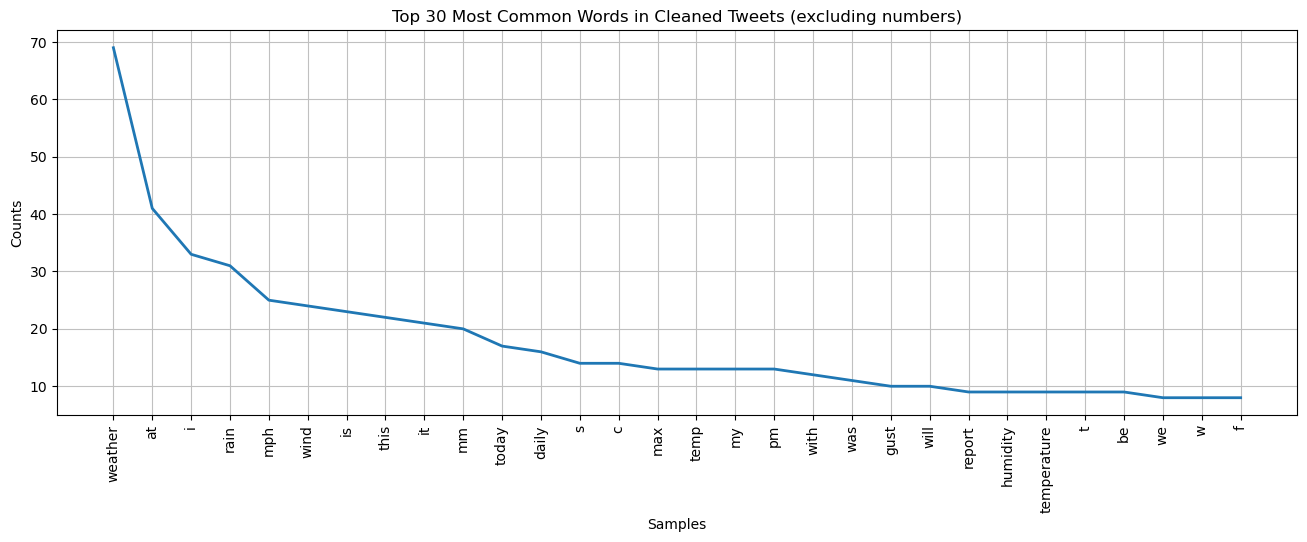

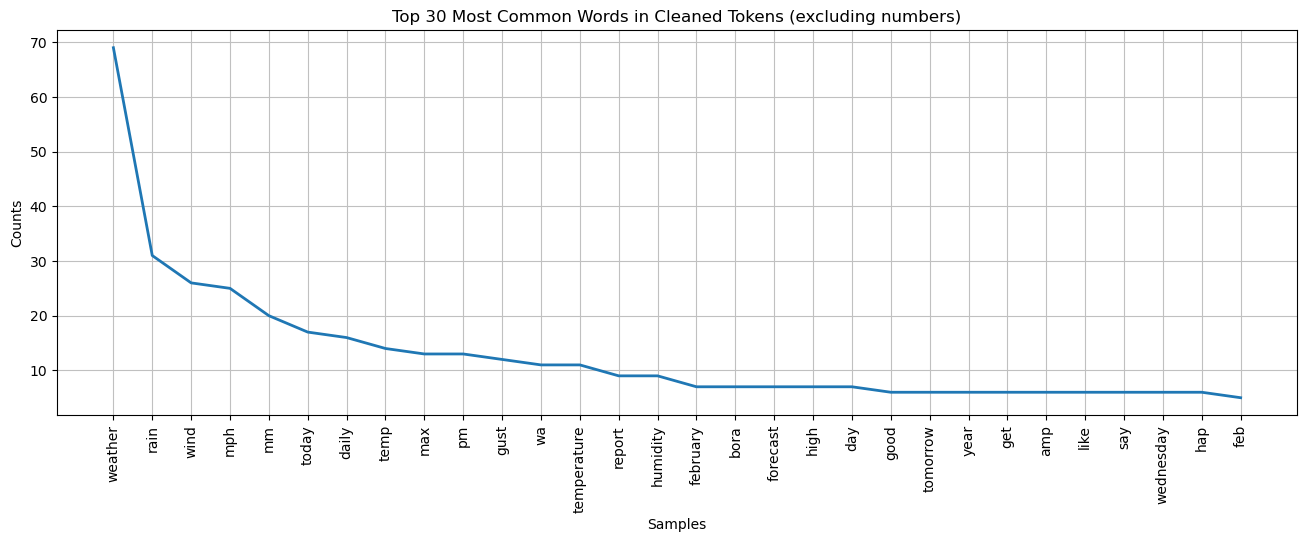

<AxesSubplot:title={'center':'Top 30 Most Common Words in Cleaned Tokens (excluding numbers)'}, xlabel='Samples', ylabel='Counts'>

In [25]:
import re
import matplotlib.pyplot as plt

# Define a regular expression to match numbers
num_pattern = re.compile(r'^\d+(\.\d+)?$')

# Function to check if a token is a number
def is_number(token):
    return bool(num_pattern.match(token))

# Calculate frequency distribution for cleaned tweets (excluding numbers)
cleaned_tweets_freq = FreqDist([token for token in sentiment_df['cleanedTweets'].apply(nltk.word_tokenize).sum() if not is_number(token)])

# Calculate frequency distribution for cleaned tokens (excluding numbers)
cleaned_tokens_freq = FreqDist([token for token in sentiment_df['cleanedTokens'].sum() if not is_number(token)])

# Plot the frequency distribution for cleaned tweets
plt.figure(figsize=(16,5))
cleaned_tweets_freq.plot(30, title='Top 30 Most Common Words in Cleaned Tweets (excluding numbers)')

# Plot the frequency distribution for cleaned tokens
plt.figure(figsize=(16,5))
cleaned_tokens_freq.plot(30, title='Top 30 Most Common Words in Cleaned Tokens (excluding numbers)')


## Frequency Distribution

In [26]:
cleaned_tweets_freq.most_common(15)

[('weather', 69),
 ('at', 41),
 ('i', 33),
 ('rain', 31),
 ('mph', 25),
 ('wind', 24),
 ('is', 23),
 ('this', 22),
 ('it', 21),
 ('mm', 20),
 ('today', 17),
 ('daily', 16),
 ('s', 14),
 ('c', 14),
 ('max', 13)]

In [27]:
cleaned_tokens_freq.most_common(15)

[('weather', 69),
 ('rain', 31),
 ('wind', 26),
 ('mph', 25),
 ('mm', 20),
 ('today', 17),
 ('daily', 16),
 ('temp', 14),
 ('max', 13),
 ('pm', 13),
 ('gust', 12),
 ('wa', 11),
 ('temperature', 11),
 ('report', 9),
 ('humidity', 9)]

# Removing Stopwords
#### here, as we can clearly see that while printing most frequent words. I got these words such as i, s, c and so on. and they dont give any meaning. These words are called stop words and they are common words in a language that usually don't carry much meaning on their own. I am removing them using the NLTK library

In [28]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stop words from a tokenized list of words
def remove_stopwords(tokens):
    return [word for word in tokens if not word in stop_words]

# Apply stop word removal to cleaned tokens column
sentiment_df['cleanedTokens'] = sentiment_df['cleanedTokens'].apply(remove_stopwords)

# Calculate frequency distribution for cleaned tokens
cleaned_freq = FreqDist(sentiment_df['cleanedTokens'].sum())

In [29]:
# Print the 20 most common words
cleaned_freq.most_common(15)

[('weather', 69),
 ('rain', 31),
 ('wind', 26),
 ('mph', 25),
 ('mm', 20),
 ('today', 17),
 ('daily', 16),
 ('temp', 14),
 ('max', 13),
 ('pm', 13),
 ('gust', 12),
 ('wa', 11),
 ('temperature', 11),
 ('report', 9),
 ('humidity', 9)]

In [30]:
# find subjectivity
def getSubjectivity(tweet):
    return TextBlob(' '.join(tweet)).sentiment.subjectivity

# find polarity
def getPolarity(tweet):
    return TextBlob(' '.join(tweet)).sentiment.polarity

sentiment_df['Subjectivity'] = sentiment_df['cleanedTokens'].apply(getSubjectivity)
sentiment_df['Polarity'] = sentiment_df['cleanedTokens'].apply(getPolarity)